In [29]:
import matplotlib.pyplot as plt
import pickle
import os
from od.social import SocialGroup
from od.network.types import ResourceAllocatorType,BaseStationType
from od.misc.interest import InterestConfig
from numpy import random

In [30]:
sg_graph_configs = [
    {
        "catalog": "veh_recv_intact_appdata_trip",
        "topic": "End-to-End Time",
        "x": "Maximum Data Generated Per Second(Unique Distribution) ",
        "y": "Time(Second)",
        "subject": ["Avg", "Max", "Min"]
    },
    {
        "catalog": "bs_appdata_txq_wait",
        "topic": "Wait Time in Downlink Queue",
        "x": "Maximum Data Generated Per Second(Unique Distribution) ",
        "y": "Time(Second)",
        "subject": ["Avg", "Max", "Min"]
    },
    {
        "catalog": "bs_appdata_tx",
        "topic": "Transfer Time",
        "x": "Maximum Data Generated Per Second(Unique Distribution) ",
        "y": "Time(Second)",
        "subject": ["Avg", "Max", "Min"]
    },
]


In [31]:
nsg_graph_configs = [
    {
        "catalog": "bs_through_put",
        "topic": "Through Put",
        "x": "Maximum Data Generated Per Second(Unique Distribution) ",
        "y": "bps",
        "subject": [bs_type for bs_type in BaseStationType]
    },
    
]


In [32]:
bs_sg_graph_configs = [
    {
        "catalog": "bs_sg_res_use_rate",
        "topic": "Social Group Utilization Rate",
        "x": "Maximum Data Generated Per Second(Unique Distribution) ",
        "y": "%",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]

In [33]:
s = [13232421, 102948123, 4419883]
a = [t for t in ResourceAllocatorType]
b = [False, True]
c = [3, 4, 5, 6, 7, 8, 9, 10]

In [34]:
interest_config = InterestConfig(None, False, 0)
stats = [[[[None for _c in c] for _b in b] for _a in a]for _s in s]
for _s , seed in enumerate(s):
    for _a, res_alloc_type in enumerate(a):
        for _b, req_rsu in enumerate(b):
            for _c, appdata_poisson in enumerate(c):
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.appdata_poisson = appdata_poisson
                with open("data/{}/{}/report.pickle".format(seed,str(interest_config)), "rb") as file:
                    stats[_s][_a][_b][_c] = pickle.load(file)

In [35]:
# create picture folder
dirpath = "pics/"
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)

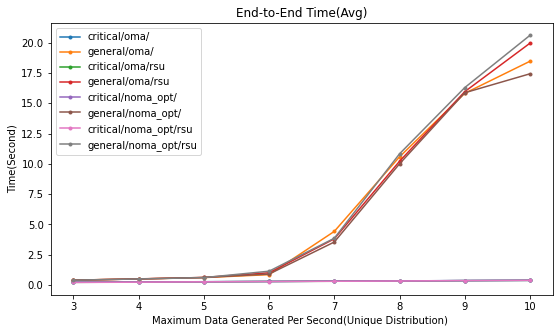

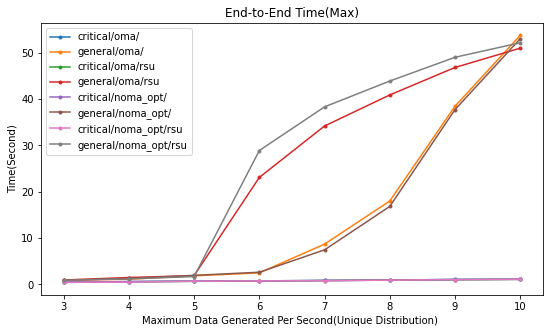

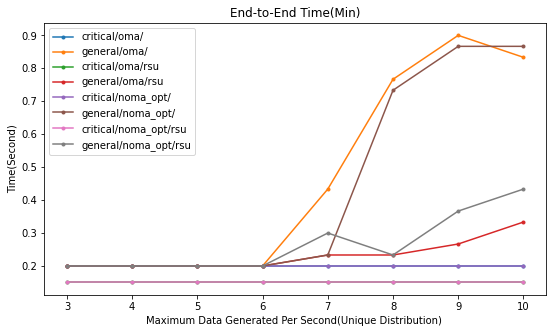

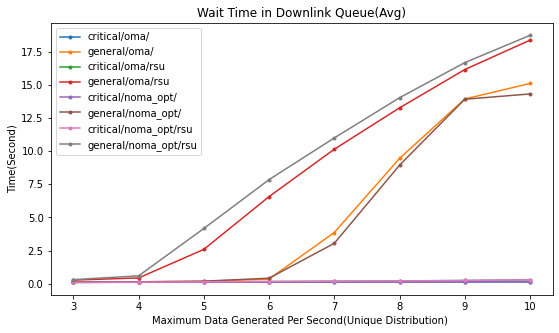

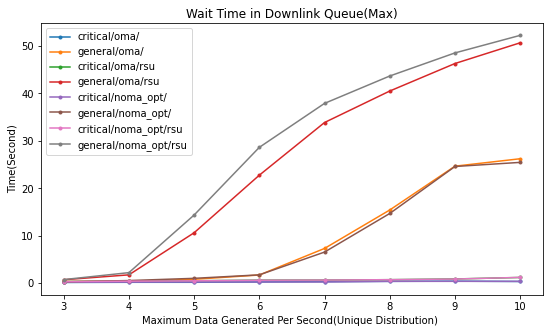

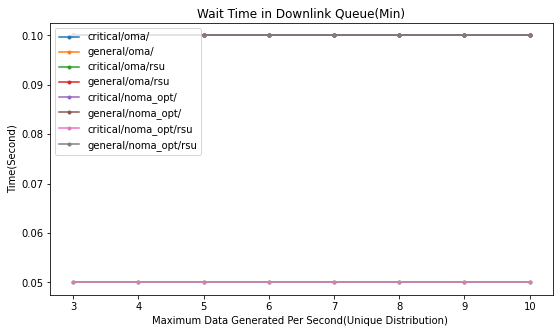

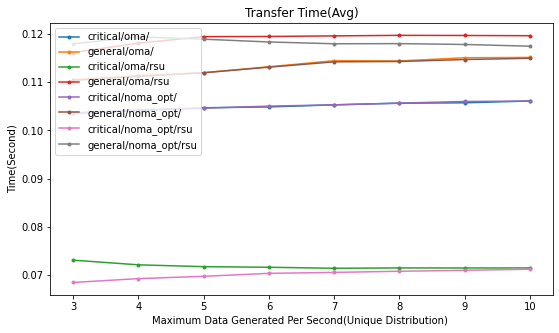

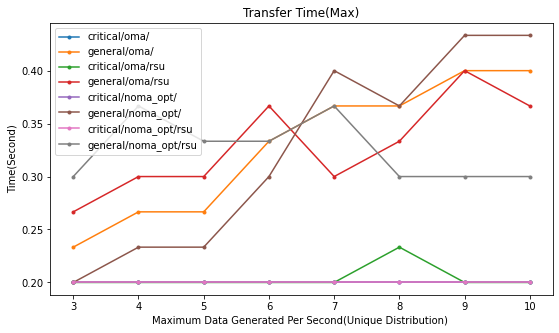

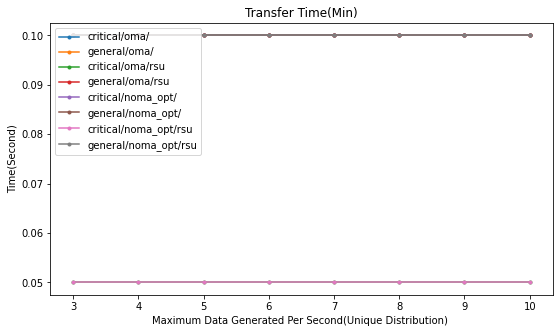

In [42]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        title = "{}({})".format(topic, subject)
        plt.figure(serial, figsize=(9, 5))
        plt.xlabel(config["x"])
        plt.ylabel(config["y"])
        plt.title(title)
        for _a in range(len(a)):
            for _b in range(len(b)):
                for sg in SocialGroup:
                    y = []
                    x = c
                    for _c in range(len(c)):
                        value = 0
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][sg][subject.lower()]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value += v
                        y.append(value/len(s))
                    plt.plot(
                        x,
                        y,
                        ".-",
                        label="{}/{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                              "rsu" if b[_b] else ""
                        )
                    )

                    #   plt.text(
                    #     c[-1],
                    #     y[-1],
                    #   )
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        plt.savefig('{}/{}.png'.format(dirpath, title))
#         plt.savefig('{}/{}.pdf'.format(dirpath, title))
        serial += 1
plt.show()


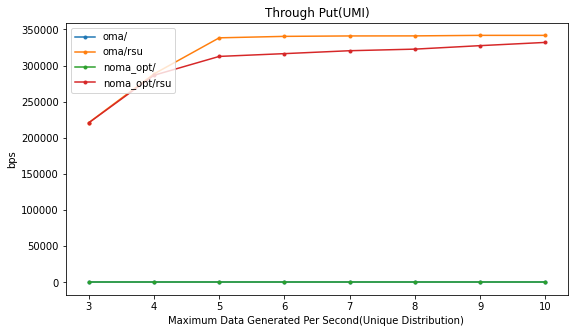

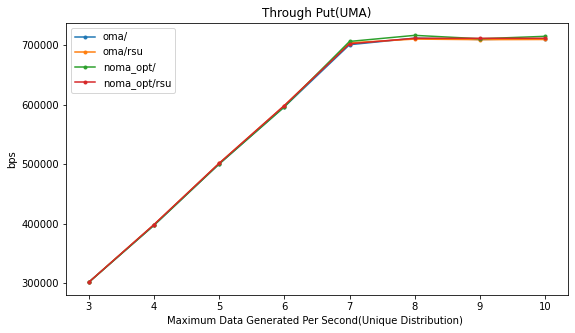

In [43]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in nsg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        title = "{}({})".format(topic, subject.name)
        plt.figure(serial, figsize=(9, 5))
        plt.xlabel(config["x"])
        plt.ylabel(config["y"])
        plt.title(title)
        for _a in range(len(a)):
            for _b in range(len(b)):
                y = []
                x = c
                for _c in range(len(c)):
                    value = 0
                    for _s in range(len(s)):
                        v = stats[_s][_a][_b][_c][catalog][subject]
                        if v == _pinf or v == _ninf:
                            v = 0
                        value += v
                    y.append(value/len(s))
                plt.plot(
                    x,
                    y,
                    ".-",
                    label="{}/{}".format(
                          a[_a].name.lower(),
                          "rsu" if b[_b] else ""
                    )
                )

                #   plt.text(
                #     c[-1],
                #     y[-1],
                #   )
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        plt.savefig('{}/{}.png'.format(dirpath, title))
#         plt.savefig('{}/{}.pdf'.format(dirpath, title))
        serial += 1
plt.show()


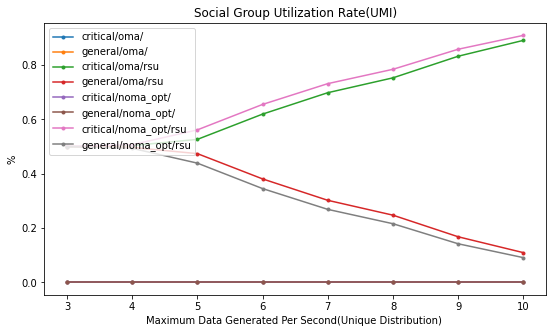

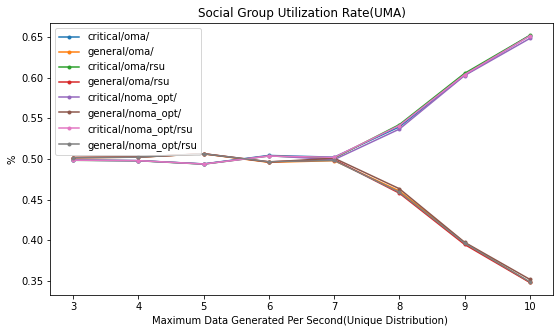

In [44]:
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in bs_sg_graph_configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        title = "{}({})".format(topic, subject.name)
        plt.figure(serial, figsize=(9, 5))
        plt.xlabel(config["x"])
        plt.ylabel(config["y"])
        plt.title(title)
        for _a in range(len(a)):
            for _b in range(len(b)):
                for sg in SocialGroup:
                    y = []
                    x = c
                    for _c in range(len(c)):
                        value = 0
                        for _s in range(len(s)):
                            v = stats[_s][_a][_b][_c][catalog][subject][sg]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value += v
                        y.append(value/len(s))
                    plt.plot(
                        x,
                        y,
                        ".-",
                        label="{}/{}/{}".format(
                              str(sg).lower(),
                              a[_a].name.lower(),
                              "rsu" if b[_b] else ""
                        )
                    )

                    #   plt.text(
                    #     c[-1],
                    #     y[-1],
                    #   )
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        plt.savefig('{}/{}.png'.format(dirpath, title))
#         plt.savefig('{}/{}.pdf'.format(dirpath, title))
        serial += 1
plt.show()


In [16]:
stats[0][0][0][0]["bs_through_put"][BaseStationType.UMI]

0.0